# Quantum Adder (WRONG)

This a an early experiment. It is not entirely accurate and I just keep it around because it still contains code that could come-in handy one day.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np

# Creates a quantum circuit adding a + b
def adder_circuit(a: int, b: int):
    # get the bit length of inputs (we take the greatest)
    input_bit_length = max(int(np.ceil(np.log2(a))), int(np.ceil(np.log2(b))))
    # result bit length is input_bit_length + 1
    result_bit_length = input_bit_length + 1
    # a
    q_a = QuantumRegister(input_bit_length, 'a')
    # b
    q_b = QuantumRegister(input_bit_length, 'b')
    # result
    q_r = QuantumRegister(result_bit_length, 'qr')
    c_r = ClassicalRegister(result_bit_length, 'cr')
    # Circuit
    adder = QuantumCircuit(q_a, q_b, q_r, c_r)
    # Initial value of a and b
    for i in range(input_bit_length):
        if 2**i & a != 0:
            adder.x(q_a[i])
        if 2**i & b != 0:
            adder.x(q_b[i])
    # Just a separation for the drawing
    adder.barrier()
    # Actual adder
    for i in range(input_bit_length):
        adder.cx(q_a[i], q_r[i])
        adder.cx(q_b[i], q_r[i])
        adder.ccx(q_a[i], q_b[i], q_r[i+1])
    # Just a separation for the drawing
    adder.barrier()
    # Measure result
    adder.measure(q_r, c_r)
    # Return circuit
    return adder

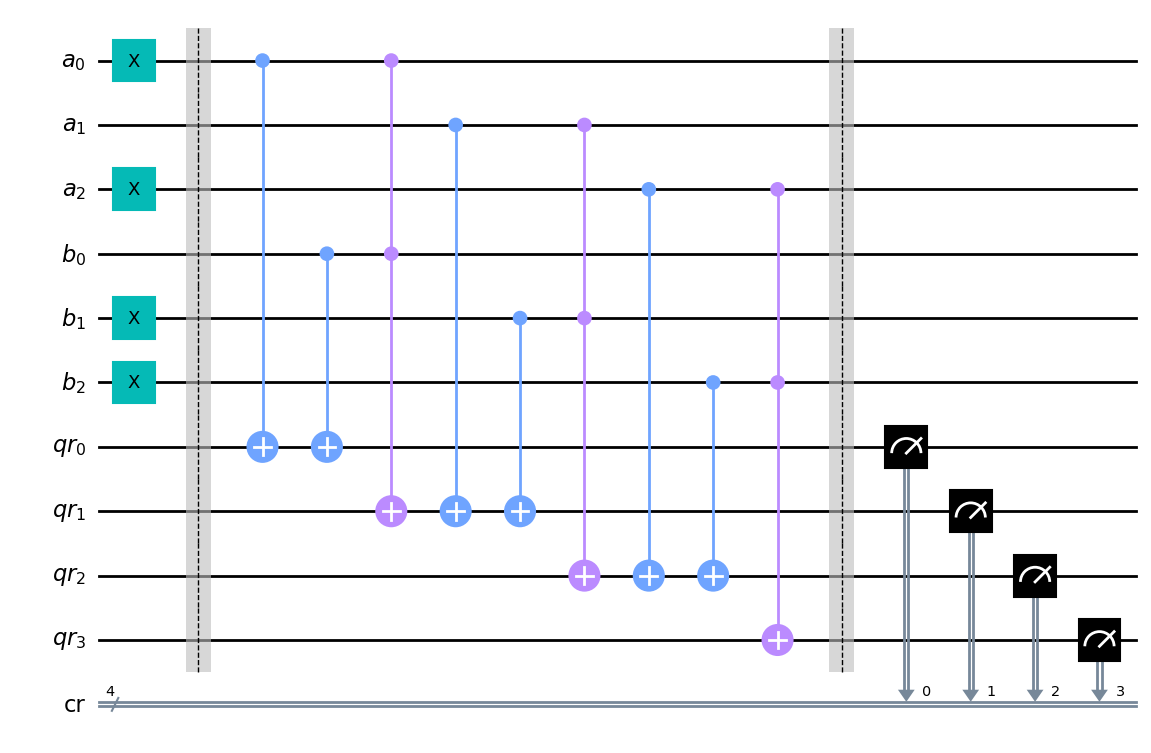

In [2]:
# Create an adder circuit for some numbers and draw it
adder = adder_circuit(5, 6)
adder.draw('mpl')

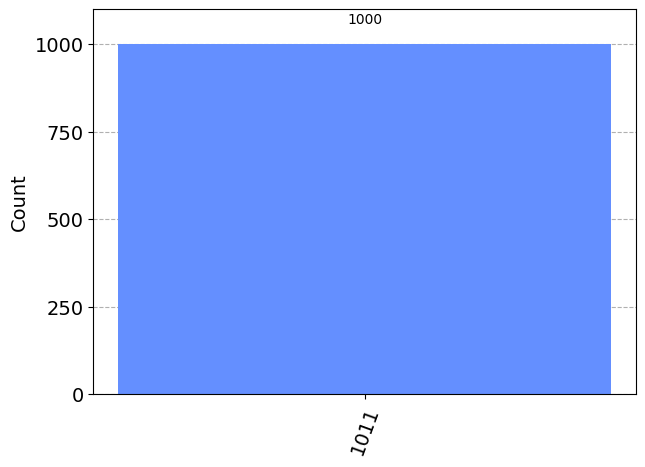

In [3]:
# Simulate the circuit with braket
from qiskit_braket_provider import BraketLocalBackend
local_simulator = BraketLocalBackend()
task = local_simulator.run(adder, shots=1000)
# Extract the counts only for the result qbits
counts = {}
for s in [m[:adder.num_clbits] for m in task.result().get_memory()]:
    counts[s] = counts.get(s, 0) + 1
# Visualize results with Qiskit
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [4]:
for res in counts:
    print(f"0b{res} = {int(res, 2)}")

0b1011 = 11


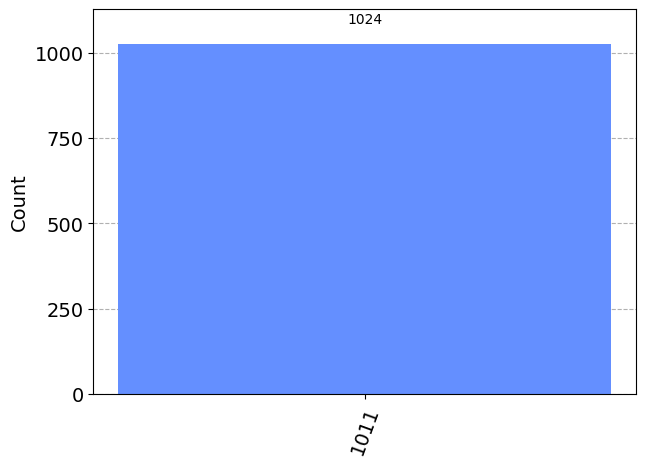

In [5]:
# Simulate with Qiskit
from qiskit import Aer, assemble
svsim = Aer.get_backend('aer_simulator')
qobj = assemble(adder)
final_state = svsim.run(qobj).result().get_counts()
from qiskit.visualization import plot_histogram
plot_histogram(final_state)

In [6]:
for res in final_state:
    print(f"0b{res} = {int(res, 2)}")

0b1011 = 11


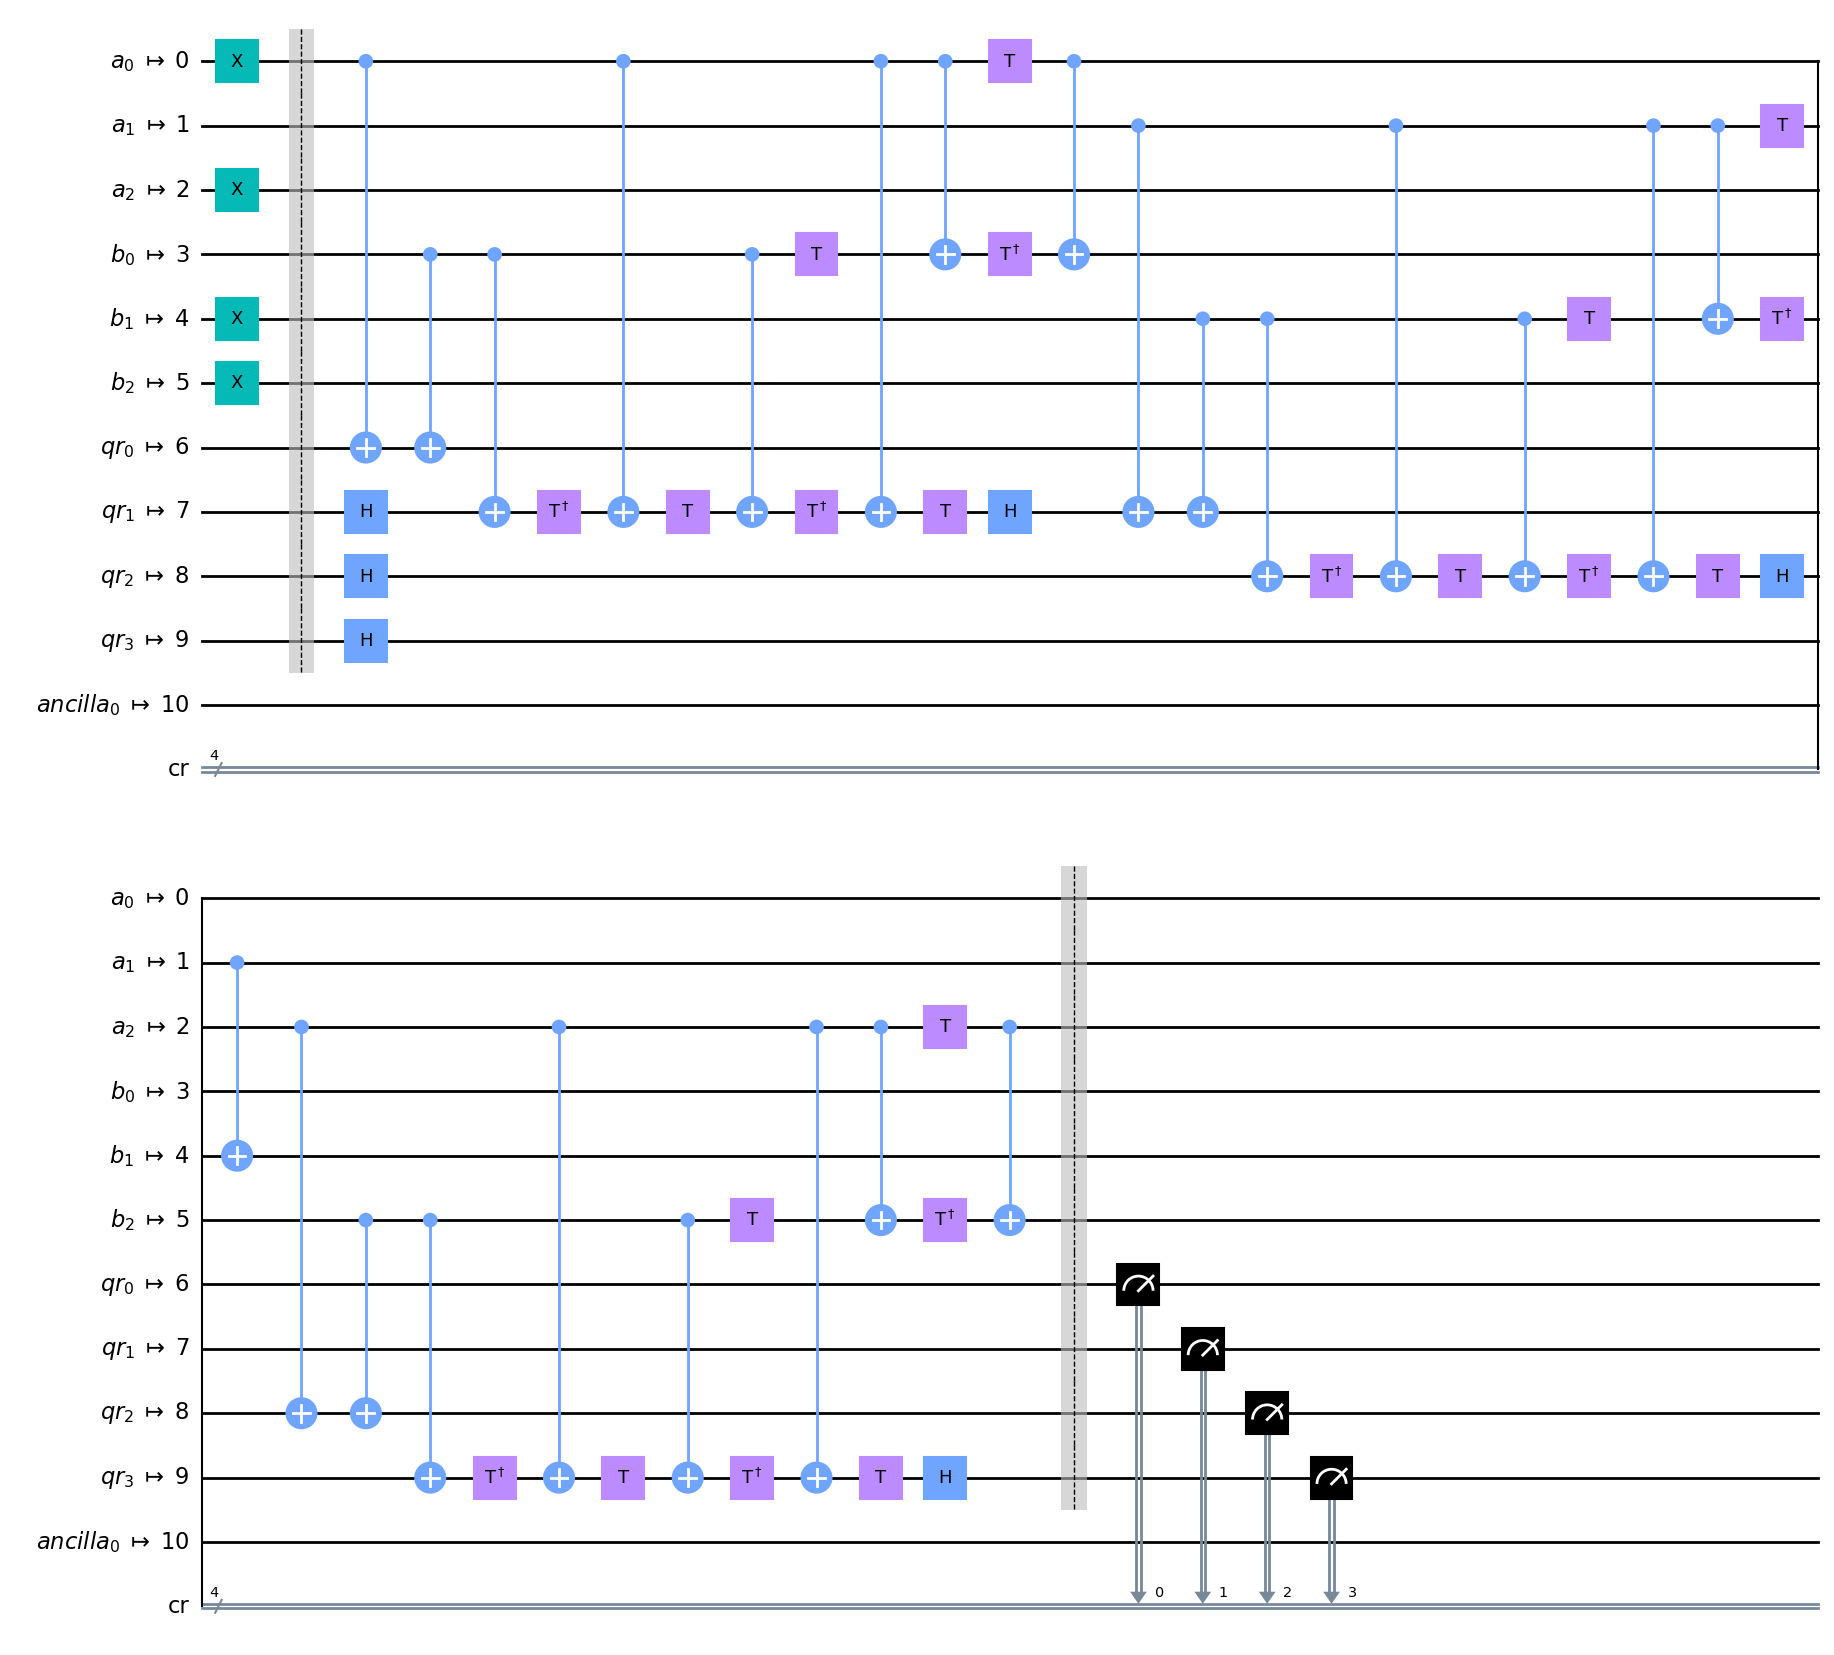

In [7]:
# Simulate the circuit with braket on IonQ
from qiskit_braket_provider import AWSBraketProvider
from qiskit import transpile
provider = AWSBraketProvider()
ionq_device = provider.get_backend("IonQ Device")
transpiled_adder = transpile(adder, backend=ionq_device)
transpiled_adder.draw('mpl')


In [10]:
ionq_job = ionq_device.run(transpiled_adder, shots=100)
job_id = ionq_job.job_id()
print(job_id)
retrieved_job = ionq_device.retrieve_job(job_id=job_id)
print(retrieved_job)


arn:aws:braket:us-east-1:403541140246:quantum-task/7cfb5ad8-1fd9-496f-b026-3be9036d31f0


In [27]:
retrieved_job.status()

<JobStatus.DONE: 'job has successfully run'>

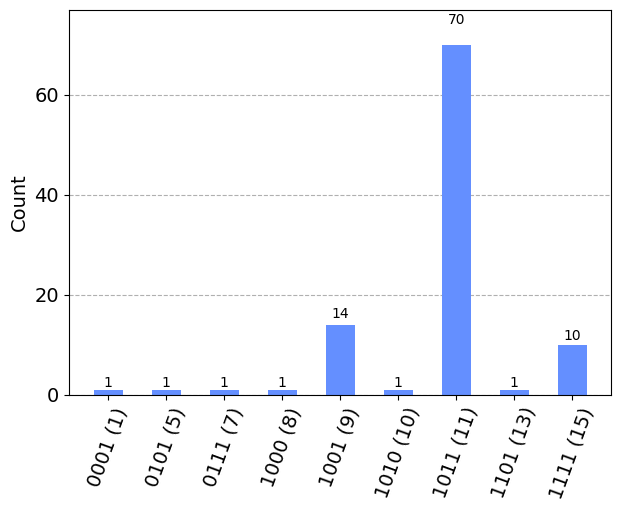

In [34]:
# Extract the counts only for the result qbits
counts = {}
for s in [m[:adder.num_clbits] for m in retrieved_job.result().get_memory()]:
    k = f"{s} ({int(s, 2)})"
    counts[k] = counts.get(k, 0) + 1
# Visualize results with Qiskit
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [33]:
for res in counts:
    print(f"0b{res} = {int(res, 2)}")

0b0001 = 1
0b0101 = 5
0b0111 = 7
0b1000 = 8
0b1001 = 9
0b1010 = 10
0b1011 = 11
0b1101 = 13
0b1111 = 15


In [156]:
from braket.circuits import Circuit, Observable
# Creates a quantum circuit adding a + b
def braket_adder_circuit(a: int, b: int):
    # get the bit length of inputs (we take the greatest)
    input_bit_length = max(int(np.ceil(np.log2(a))), int(np.ceil(np.log2(b))))
    # result bit length is input_bit_length + 1
    result_bit_length = input_bit_length + 1
    adder = Circuit()
    # Initial value of a and b
    for i in range(input_bit_length):
        if 2**i & a != 0:
            adder.x(i)
        if 2**i & b != 0:
            adder.x(input_bit_length + i)
    for i in range(input_bit_length):
        adder.cnot(i, input_bit_length * 2 + i)
        adder.cnot(input_bit_length + i, input_bit_length * 2 + i)
        adder.ccnot(i, input_bit_length + i, input_bit_length * 2 + i + 1)
    return adder

In [157]:
# Simulate the circuit with braket on Aspen-M-3
from braket.aws import AwsDevice
from qiskit_braket_provider.providers.adapter import convert_qiskit_to_braket_circuit
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")
braket_adder = braket_adder_circuit(5, 6)
print(braket_adder)


T  : |0|1|2|3|4|5|6|7|8|9|
                          
q0 : -X-C---C-------------
        |   |             
q1 : ---|---|-C---C-------
        |   | |   |       
q2 : -X-|---|-|---|-C---C-
        |   | |   | |   | 
q3 : ---|-C-C-|---|-|---|-
        | | | |   | |   | 
q4 : -X-|-|-|-|-C-C-|---|-
        | | | | | | |   | 
q5 : -X-|-|-|-|-|-|-|-C-C-
        | | | | | | | | | 
q6 : ---X-X-|-|-|-|-|-|-|-
            | | | | | | | 
q7 : -------X-X-X-|-|-|-|-
                  | | | | 
q8 : -------------X-X-X-|-
                        | 
q9 : -------------------X-

T  : |0|1|2|3|4|5|6|7|8|9|


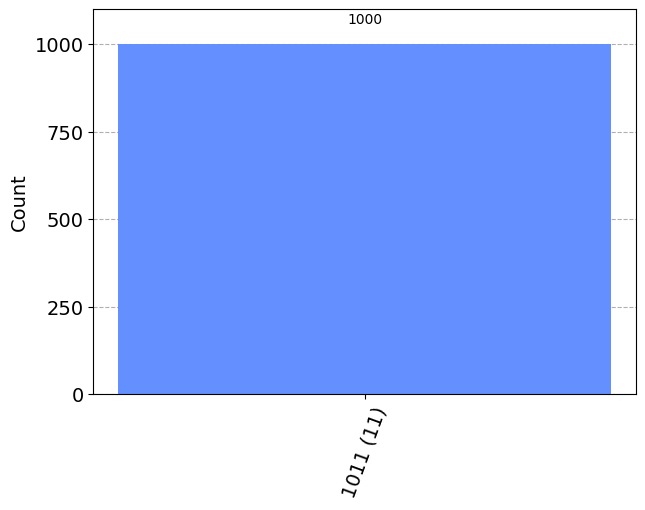

In [158]:
# Simulate the circuit with braket
from braket.devices import LocalSimulator
local_simulator = LocalSimulator()
local_task = local_simulator.run(braket_adder, shots=1000)
counts = {}
for s, c in local_task.result().measurement_counts.items():
    l = s[-adder.num_clbits:][::-1]
    k = f"{l} ({int(l, 2)})"
    counts[k] = counts.get(k, 0) + c
# Visualize results with Qiskit
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [160]:
rigetti_task = rigetti.run(braket_adder, shots=1000)
rigetti_task_id = rigetti_task.id
print(rigetti_task_id)

arn:aws:braket:us-west-1:403541140246:quantum-task/057861e9-b85e-4ff6-a566-9351560c30b2


In [161]:
from braket.aws import AwsQuantumTask
task_load = AwsQuantumTask(arn=rigetti_task_id)
print('Status of task:', task_load.state())

Status of task: QUEUED


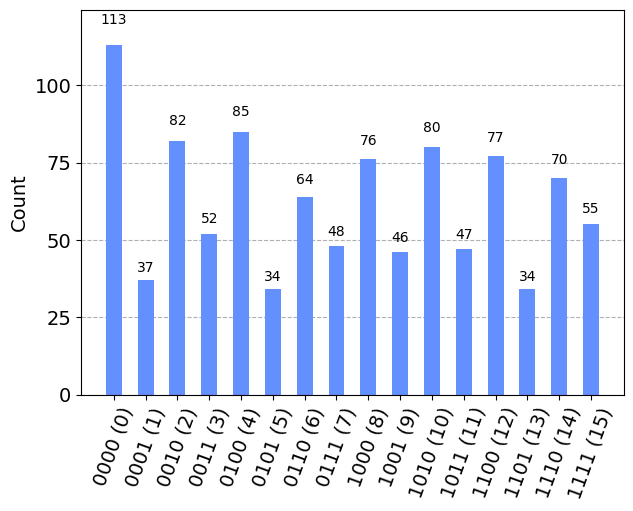

In [141]:
counts = {}
for s, c in task_load.result().measurement_counts.items():
    l = s[-adder.num_clbits:][::-1]
    k = f"{l} ({int(l, 2)})"
    counts[k] = counts.get(k, 0) + c
# Visualize results with Qiskit
from qiskit.visualization import plot_histogram
plot_histogram(counts)